In [ ]:
import cv2
import mediapipe as mp
import urllib.request
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
import PyQt5
from PIL import Image
from IPython.display import Video
import nb_helpers
import os
import csv

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic
mp_pose = mp.solutions.pose
mp_face_mesh = mp.solutions.face_mesh

Extract frame from video

In [ ]:
#for all video in data/video folder extract frames
for v in os.listdir('data/video'):
    vidcap = cv2.VideoCapture('data/video/'+v)
    success,image = vidcap.read()
    count = 0
    while success:
      cv2.imwrite("data/frames/%s_frame%d.jpg" % (v,count), image)     # save frame as JPEG file
      success,image = vidcap.read()
      count += 1
    
    print(f"Frames estratti da {v}")

face mesh and data preprocessing

In [ ]:
# Define image filename and drawing specifications
files = os.listdir('data/frames')
print(len(files))

for file in files:
    print(f"Elaborazione di {file}")
    drawing_spec = mp_drawing.DrawingSpec(thickness=1, circle_radius=1)

    # Create a face mesh object
    with mp_face_mesh.FaceMesh(
            static_image_mode=True,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5) as face_mesh:

        # Read image file
        image = cv2.imread(f"data/frames/{file}")
        #print current path
        print(os.getcwd())
        if image is None:
            raise ValueError(f"Immagine {file} non trovata o non caricata correttamente.")

        # Rileva il volto e ridimensiona l'immagine
        mp_face_detection = mp.solutions.face_detection
        with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detection:
            detection_results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            if detection_results.detections:
                # Ottieni bounding box normalizzato
                bboxC = detection_results.detections[0].location_data.relative_bounding_box
                ih, iw, _ = image.shape

                # Converti a coordinate assolute
                x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)

                # Aggiungi margine del 25%
                margin_w, margin_h = int(0.25 * w), int(0.25 * h)
                x, y = max(0, x - margin_w), max(0, y - margin_h)
                w, h = min(iw, w + 2 * margin_w), min(ih, h + 2 * margin_h)

                # Ritaglia il volto
                face_crop = image[y:y+h, x:x+w]

                # Ridimensiona a 256x256
                image = cv2.resize(face_crop, (256, 256))

        # Ora l'immagine ritagliata e ridimensionata viene usata per il Face Mesh
        results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Define boolean corresponding to whether or not a face was detected in the image
    face_found = bool(results.multi_face_landmarks)

    if face_found:
        # Create a copy of the image
        annotated_image = image.copy()
    
        # Draw landmarks on face
        mp_drawing.draw_landmarks(
            image=annotated_image,
            landmark_list=results.multi_face_landmarks[0],
            connections=mp_face_mesh.FACEMESH_TESSELATION,
            landmark_drawing_spec=None,
            connection_drawing_spec=mp_drawing_styles
            .get_default_face_mesh_tesselation_style())
    
        # Save image
        cv2.imwrite(f"data/modified/{file}", annotated_image)
    
        print(f"Dimensione immagine: {image.shape}")
    
        # Extract coordinates of landmarks
        landmarks = results.multi_face_landmarks[0].landmark  # Get the first face's landmarksimage
    
        # Define the CSV file name
        csv_filename = f"data/csv/{file.replace('.jpg', '.csv')}"
        print(f"Salvataggio coordinate in {csv_filename}")
    
        # Write the coordinates to the CSV file
        with open(csv_filename, mode='w', newline='') as file:
            writer = csv.writer(file)
    
            # Write the header
            writer.writerow(['Index', 'X', 'Y', 'Z'])
    
            # Write the landmark coordinates
            for i, landmark in enumerate(landmarks):
                writer.writerow([i, landmark.x, landmark.y, landmark.z])
    
        print(f"Le coordinate sono state salvate in {csv_filename}")

Landmarks and csv file

Elaborazione di My video - Data.mp4_frame0.jpg
Elaborazione di My video - Data.mp4_frame1.jpg
Elaborazione di My video - Data.mp4_frame10.jpg
Elaborazione di My video - Data.mp4_frame11.jpg
Elaborazione di My video - Data.mp4_frame12.jpg
Elaborazione di My video - Data.mp4_frame13.jpg
Elaborazione di My video - Data.mp4_frame14.jpg
Elaborazione di My video - Data.mp4_frame15.jpg
Elaborazione di My video - Data.mp4_frame16.jpg
Elaborazione di My video - Data.mp4_frame17.jpg


I0000 00:00:1742487650.249209   15327 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742487650.250182   41736 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742487650.252770   41727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742487650.267165   41722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1742487650.271794   15327 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742487650.272564   41746 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742487650.275183   41739 inference_feedback_manager.cc:114] Feedback 

Elaborazione di My video - Data.mp4_frame18.jpg
Elaborazione di My video - Data.mp4_frame19.jpg
Elaborazione di My video - Data.mp4_frame2.jpg
Elaborazione di My video - Data.mp4_frame20.jpg
Elaborazione di My video - Data.mp4_frame21.jpg
Elaborazione di My video - Data.mp4_frame22.jpg
Elaborazione di My video - Data.mp4_frame23.jpg
Elaborazione di My video - Data.mp4_frame24.jpg
Elaborazione di My video - Data.mp4_frame25.jpg
Elaborazione di My video - Data.mp4_frame26.jpg
Elaborazione di My video - Data.mp4_frame27.jpg
Elaborazione di My video - Data.mp4_frame28.jpg


I0000 00:00:1742487650.463667   15327 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742487650.464305   41846 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742487650.466184   41838 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1742487650.481731   15327 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742487650.482376   41856 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742487650.484249   41850 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1742487650.499397   15327 gl_context_egl.cc:85] Successfully initializ

Elaborazione di My video - Data.mp4_frame29.jpg
Elaborazione di My video - Data.mp4_frame3.jpg
Elaborazione di My video - Data.mp4_frame30.jpg
Elaborazione di My video - Data.mp4_frame31.jpg
Elaborazione di My video - Data.mp4_frame32.jpg
Elaborazione di My video - Data.mp4_frame33.jpg
Elaborazione di My video - Data.mp4_frame34.jpg
Elaborazione di My video - Data.mp4_frame35.jpg
Elaborazione di My video - Data.mp4_frame36.jpg
Elaborazione di My video - Data.mp4_frame37.jpg
Elaborazione di My video - Data.mp4_frame38.jpg


I0000 00:00:1742487650.871577   15327 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742487650.872221   42066 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742487650.874096   42060 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1742487650.892086   15327 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742487650.892783   42076 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742487650.894984   42070 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1742487650.914113   15327 gl_context_egl.cc:85] Successfully initializ

Elaborazione di My video - Data.mp4_frame39.jpg
Elaborazione di My video - Data.mp4_frame4.jpg
Elaborazione di My video - Data.mp4_frame40.jpg
Elaborazione di My video - Data.mp4_frame41.jpg
Elaborazione di My video - Data.mp4_frame42.jpg
Elaborazione di My video - Data.mp4_frame43.jpg
Elaborazione di My video - Data.mp4_frame44.jpg
Elaborazione di My video - Data.mp4_frame45.jpg
Elaborazione di My video - Data.mp4_frame46.jpg
Elaborazione di My video - Data.mp4_frame47.jpg
Elaborazione di My video - Data.mp4_frame48.jpg


I0000 00:00:1742487651.079658   15327 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742487651.080964   42176 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742487651.083014   42167 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1742487651.100261   15327 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742487651.101286   42186 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742487651.103188   42179 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1742487651.120500   15327 gl_context_egl.cc:85] Successfully initializ

Elaborazione di My video - Data.mp4_frame49.jpg
Elaborazione di My video - Data.mp4_frame5.jpg
Elaborazione di My video - Data.mp4_frame50.jpg
Elaborazione di My video - Data.mp4_frame51.jpg
Elaborazione di My video - Data.mp4_frame52.jpg
Elaborazione di My video - Data.mp4_frame53.jpg
Elaborazione di My video - Data.mp4_frame54.jpg
Elaborazione di My video - Data.mp4_frame55.jpg
Elaborazione di My video - Data.mp4_frame56.jpg
Elaborazione di My video - Data.mp4_frame57.jpg
Elaborazione di My video - Data.mp4_frame58.jpg


I0000 00:00:1742487651.281945   15327 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742487651.282584   42286 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742487651.284586   42279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1742487651.301896   15327 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742487651.303201   42296 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742487651.305233   42289 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1742487651.322171   15327 gl_context_egl.cc:85] Successfully initializ

Elaborazione di My video - Data.mp4_frame59.jpg
Elaborazione di My video - Data.mp4_frame6.jpg
Elaborazione di My video - Data.mp4_frame60.jpg
Elaborazione di My video - Data.mp4_frame61.jpg
Elaborazione di My video - Data.mp4_frame62.jpg
Elaborazione di My video - Data.mp4_frame63.jpg
Elaborazione di My video - Data.mp4_frame64.jpg
Elaborazione di My video - Data.mp4_frame65.jpg
Elaborazione di My video - Data.mp4_frame66.jpg
Elaborazione di My video - Data.mp4_frame67.jpg
Elaborazione di My video - Data.mp4_frame68.jpg


I0000 00:00:1742487651.489512   15327 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742487651.491657   42396 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742487651.493796   42390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1742487651.511146   15327 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742487651.513849   42406 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742487651.516164   42400 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1742487651.532042   15327 gl_context_egl.cc:85] Successfully initializ

Elaborazione di My video - Data.mp4_frame69.jpg
Elaborazione di My video - Data.mp4_frame7.jpg
Elaborazione di My video - Data.mp4_frame70.jpg
Elaborazione di My video - Data.mp4_frame71.jpg
Elaborazione di My video - Data.mp4_frame72.jpg
Elaborazione di My video - Data.mp4_frame73.jpg
Elaborazione di My video - Data.mp4_frame74.jpg
Elaborazione di My video - Data.mp4_frame75.jpg
Elaborazione di My video - Data.mp4_frame76.jpg
Elaborazione di My video - Data.mp4_frame77.jpg
Elaborazione di My video - Data.mp4_frame78.jpg
Elaborazione di My video - Data.mp4_frame79.jpg
Elaborazione di My video - Data.mp4_frame8.jpg
Elaborazione di My video - Data.mp4_frame80.jpg
Elaborazione di My video - Data.mp4_frame9.jpg


I0000 00:00:1742487651.692349   15327 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742487651.692949   42506 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742487651.694770   42498 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1742487651.711853   15327 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1742487651.712757   42516 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 23.2.1-1ubuntu3.1~22.04.3), renderer: Mesa Intel(R) UHD Graphics (CML GT2)
W0000 00:00:1742487651.714721   42509 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1742487651.731541   15327 gl_context_egl.cc:85] Successfully initializ

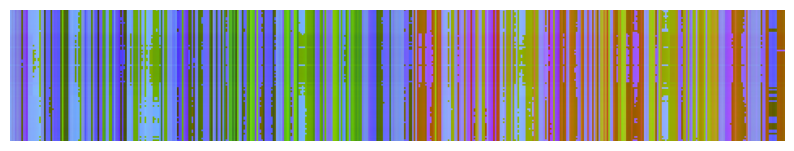

In [39]:
import os
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

# Inizializza MediaPipe
mp_face_mesh = mp.solutions.face_mesh
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

def process_frames_and_plot():
    files = sorted(os.listdir('data/frames'))
    num_frames = len(files)
    landmark_tensor = np.zeros((num_frames, 478, 3), dtype=np.float32)

    with mp_face_mesh.FaceMesh(
            static_image_mode=True,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5) as face_mesh:
        
        for i, file in enumerate(files):
            print(f"Elaborazione di {file}")
            image = cv2.imread(f"data/frames/{file}")
            if image is None:
                raise ValueError(f"Immagine {file} non trovata o non caricata correttamente.")

            # Rileva il volto
            with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detection:
                detection_results = face_detection.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                if detection_results.detections:
                    bboxC = detection_results.detections[0].location_data.relative_bounding_box
                    ih, iw, _ = image.shape
                    x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
                    margin_w, margin_h = int(0.25 * w), int(0.25 * h)
                    x, y = max(0, x - margin_w), max(0, y - margin_h)
                    w, h = min(iw, w + 2 * margin_w), min(ih, h + 2 * margin_h)
                    face_crop = image[y:y+h, x:x+w]
                    image = cv2.resize(face_crop, (256, 256))
            
            # Ottieni i landmark
            results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            if results.multi_face_landmarks:
                for idx, landmark in enumerate(results.multi_face_landmarks[0].landmark):
                    landmark_tensor[i, idx] = [landmark.x, landmark.y, landmark.z]
    
    # Usa i canali rosso, verde e blu
    rgb_tensor = np.zeros_like(landmark_tensor, dtype=np.uint8)
    rgb_tensor[:, :, 0] = landmark_tensor[:, :, 0] * 255  # Rosso
    rgb_tensor[:, :, 1] = landmark_tensor[:, :, 1] * 255  # Verde
    rgb_tensor[:, :, 2] = landmark_tensor[:, :, 2] * 255  # Blu
    
    # Plot del tensore come immagine
    plt.figure(figsize=(10, 5))
    plt.imshow(rgb_tensor.reshape(num_frames, 478, 3))  # Visualizza l'immagine
    plt.axis('off')
    plt.show()
    
    #save image
    plt.imsave('data/landmarks.jpg', rgb_tensor.reshape(num_frames, 478, 3))

process_frames_and_plot()


plot

In [ ]:
#scatter plot of csv

import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Funzione per caricare i punti di riferimento da un CSV
def load_landmarks(csv_filename):
    landmarks = []
    with open(csv_filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Salta l'intestazione
        for row in reader:
            # Aggiungi le coordinate (x, y, z) come tuple
            landmarks.append((float(row[1]), float(row[2]), float(row[3])))
    return landmarks

# Funzione per creare lo scatter plot 3D
def plot_landmarks_scatter(csv_filename):
    landmarks = load_landmarks(csv_filename)

    # Estrai le coordinate x, y, z
    x_coords = [landmark[0] for landmark in landmarks]
    y_coords = [landmark[1] for landmark in landmarks]
    z_coords = [landmark[2] for landmark in landmarks]

    # Crea la figura e l'asse 3D
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Crea lo scatter plot
    ax.scatter(x_coords, y_coords, z_coords, c='r', marker='o')

    # Aggiungi etichette agli assi
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')

    # Mostra il plot
    plt.show()

# Usa la funzione per creare il plot
csv_file = 'landmarks_coordinates.csv'  # Sostituisci con il tuo file CSV
plot_landmarks_scatter(csv_file)

